In [47]:
import json
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import folium as fl
import datetime
sns.set(style="whitegrid")
%matplotlib inline
from ipywidgets import *
from ipywidgets import interact, interactive, fixed
from IPython.display import display
#from IPython.html import widgets
import ipywidgets as widgets


We create a dataframe with the relevant battles info

In [48]:
battles = pd.DataFrame([json.loads(line) for line in open("../datasets/battle-features-0.json")])
btp = battles[['start_date','longitude','latitude','dates_bc','end_date']]
btp = btp[pd.notnull(btp['start_date'])]
btp = btp[pd.notnull(btp['longitude'])]
btp = btp[pd.notnull(btp['latitude'])]

btpbc=btp[btp.dates_bc==True]
btpbc['year'] = [-datetime.datetime.strptime(date, "%Y-%m-%d").year for date in btpbc['start_date']]
btpnbc=btp[btp.dates_bc==False]
btpnbc['year'] = [datetime.datetime.strptime(date, "%Y-%m-%d").year for date in btpnbc['start_date']]
btp=btpbc.append(btpnbc)

bins = [-2500,-2250,-2000,-1750,-1500,-1250,-1000,-750,-500,-250,0,250,500,750,1000,1250,1500,1750,2000,2250]
bins_labels=[-2500,-2250,-2000,-1750,-1500,-1250,-1000,-750,-500,-250,0,250,500,750,1000,1250,1500,1750,2000]
lengthbins = [-1,5,10,15,50,100,150,200,500,1000,2000,3000]
lengthbins_labels=[0,5,10,15,50,100,150,200,500,1000,2000]


/Users/margueritedelcourt/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/margueritedelcourt/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We plot the available battles we have in our dataset by dates

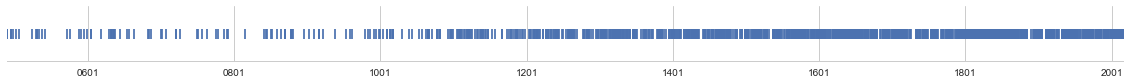

In [49]:
X=[datetime.datetime.strptime(date, "%Y-%m-%d") for date in btp['start_date']]
fig, ax = plt.subplots(figsize=(20,1))
ax.scatter(X, [1]*len(X),
           marker='|', s=100)

ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.get_yaxis().set_ticklabels([])
day = pd.to_timedelta("1", unit='D')
plt.xlim(X[0] - day, X[-1] + day)
plt.show()

We plot a histogram showing the amount of battles we have in different time intervals

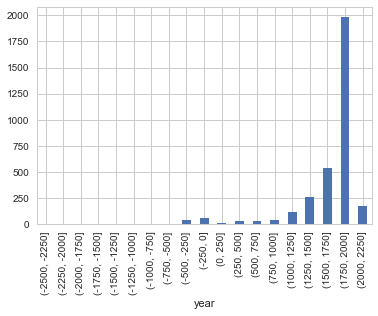

In [50]:
btpyear=btp.groupby(pd.cut(btp['year'], bins=bins)).year
years_count = btpyear.count()
years_count.plot(kind='bar')


We now plot histograms of time duration of battles by time intervals. You can use the scroller to change the time interval to display. Note that in some of them, no battles are found. 

In [51]:

btp = btp.groupby(pd.cut(btp['year'],bins=bins, labels=bins_labels))[['start_date','end_date','latitude','longitude']]
  
def plotDurationByPeriod(b):
    try:
        btpnow = btp.get_group(b)
        btpnow['end_date']=btpnow['end_date'].fillna(btpnow['start_date'])
        btpnow['start_date'] = btpnow['start_date'].astype('datetime64[ns]')
        btpnow['end_date'] = btpnow['end_date'].astype('datetime64[ns]')
        length=[]
        btpnow=btpnow.reset_index()
        for i in range(0,len(btpnow['start_date'])):
            #print(pd.Timedelta(btp1.end_date[i]-btp1.start_date[i]))
            length+=[pd.Timedelta(btpnow.end_date[i]-btpnow.start_date[i])]
        btpnow['length'] = length
        btpnow['length']=btpnow['length'].astype('timedelta64[D]')
        days=btpnow.groupby(pd.cut(btpnow['length'], bins=lengthbins, labels=lengthbins_labels))['length']
        days_count = days.count()
        plt.figure(i)
        days_count.plot(kind='bar')
        plt.title('duration of battles in cluster')
    except:
        print("No battles in time interval")


In [52]:
interact(plotDurationByPeriod,b=(-2500,2000,250) )

interactive(children=(IntSlider(value=-250, description='b', max=2000, min=-2500, step=250), Output()), _dom_classes=('widget-interact',))

<function __main__.plotDurationByPeriod>

We plot a heatmap of battles by time intervals. Again you may use the scroller to change the time period to display. Some time intervals having no battles to display, it shows an empty map.

In [44]:
def plotHeatMap(b):
    try:
        battles = btp.get_group(b)
        m = fl.Map()
        coord_df = battles[["latitude", "longitude"]].dropna()
        coords = [[lat, long] for lat, long in zip(coord_df["latitude"], coord_df["longitude"])]
        HeatMap(coords).add_to(m)
        display(m)
    except:
        m = fl.Map()
        display(m)

In [45]:
interact(plotHeatMap, b=(-2500,2000,250))

interactive(children=(IntSlider(value=-250, description='b', max=2000, min=-2500, step=250), Output()), _dom_classes=('widget-interact',))

<function __main__.plotHeatMap>